In [2]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from utils.utils import load_disc_model
from utils.discrim_training import HideAttackExp
from utils.data import load_Ford_A, transform_data, MyDataset
from models.models import LSTM_net
from utils.estimation import plot_aa_metrics

from utils.attacks import fgsm_disc_attack, fgsm_attack, fgsm_reg_attack

# Functions

In [3]:
def load_data(name, path='results/Ford_A/Regular_Disc/Same_disc/', dataset='Ford_A' , model_id=0):

    df_all = pd.DataFrame()

    if 'original' not in name:
        for alpha in [0, 0.001, 0.01, 0.1, 1, 10, 100]:
            try:
                
                df_loc = pd.read_csv(path + f'aa_res_{dataset}_{model_id}_alpha={alpha}.csv', index_col=0)
                df_loc['method_attack'] = name
                df_loc['alpha'] = alpha
                df_all = pd.concat([df_all, df_loc])
            except:
                print('Fail with Alpha', alpha, name)


    else:
        df_all = pd.read_csv(path + f'aa_res_{dataset}_{model_id}.csv', index_col=0)
        df_all['method_attack'] = name
        df_all['alpha'] = 0

    return df_all

def load_all_datasets(dict_name_path, dataset='Ford_A'):

    df_all = pd.DataFrame([])

    for name, (path, id) in dict_name_path.items():
        df_loc = load_data(name, path, dataset, id)
        df_all = pd.concat([df_all, df_loc])

    return df_all


In [4]:
def plot_attack(models_for_viz, style, alpha, eps, dataset='Ford_A', metrics=['ACC', 'HID'], y_disc_log=False, 
                figsize=None, legend=True, inverse=False):
    
    if isinstance(alpha, float) or isinstance(alpha, int):
        alpha_dict = dict()
        for key in models_for_viz:
            alpha_dict[key] = alpha
        alpha = alpha_dict

    if isinstance(eps, float) or isinstance(eps, int):
        eps_dict = dict()
        for key in models_for_viz:
            eps_dict[key] = eps
        eps = eps_dict
    
    df_res = load_all_datasets(models_for_viz, dataset=dataset)
    df_res['eps'] = df_res['eps'].round(4)

    if not figsize:
        plt.figure(figsize=(5*len(metrics) + 3, 7))
    else:
        plt.figure(figsize=figsize)
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i+1)
        metric_name = 'Effectiveness' if metric == 'ACC' else 'Concealability'
        plt.title(metric_name, fontsize=16)
        for method_attack in df_res['method_attack'].unique():
            if method_attack not in style:
                continue
            mask = (df_res['method_attack'] == method_attack) & \
                (df_res['eps'] == eps[method_attack]) & \
                (df_res['alpha'].isin([0, alpha[method_attack]]))
            
            df_filter_viz = df_res[mask]
            metrigs_logs = df_filter_viz[metric]
            if inverse:
                metrigs_logs = 1 - metrigs_logs
            plt.plot(df_filter_viz['n steps'], metrigs_logs, label=method_attack, 
                    **style[method_attack])

        plt.xlabel('steps of attack', fontsize=14)
        if inverse:
            plt.ylabel('1 - Accuracy', fontsize=14)
        else:
            plt.ylabel('Accuracy', fontsize=14)

        if legend:
            plt.legend()
            
        if metric == 'HID' and y_disc_log:
            plt.yscale('log')
        plt.grid()
    plt.show()

In [9]:
def plot_attack_scatter(
    models_for_viz, 
    style, 
    alpha, 
    eps, 
    step = 50,
    dataset='Ford_A', 
    figsize=None, 
    legend=True
):
    
    if isinstance(alpha, float) or isinstance(alpha, int):
        alpha_dict = dict()
        for key in models_for_viz:
            alpha_dict[key] = alpha
        alpha = alpha_dict

    if isinstance(eps, float) or isinstance(eps, int):
        eps_dict = dict()
        for key in models_for_viz:
            eps_dict[key] = eps
        eps = eps_dict
    
    df_res = load_all_datasets(models_for_viz, dataset=dataset)
    df_res['eps'] = df_res['eps'].round(4)

    plt.figure(figsize=(10, 10))
    if figsize:
        plt.figure(figsize=figsize)

    plt.title('Attacks', fontsize=16)

    for method_attack in df_res['method_attack'].unique():
        if method_attack not in style:
            continue
        mask = (df_res['method_attack'] == method_attack) & \
            (df_res['eps'] == eps[method_attack]) & \
            (df_res['alpha'].isin([0, alpha[method_attack]])) & \
            (df_res['n steps'] == step)
        
        df_filter_viz = df_res[mask]

        plt.scatter(
            1 - df_filter_viz['HID'], 
            1 - df_filter_viz['ACC'], 
            label=method_attack, 
            **style[method_attack]
        )

    plt.xlabel('Concealability', fontsize=14)
    plt.ylabel('Effectiveness', fontsize=14)
    plt.ylim([0.0, 1.0])
    #plt.yscale('log')

    if legend:
        plt.legend()
        
    plt.grid()
    plt.show()

# Discriminator model

In [37]:
def load_experiment(model_name='fgsm_attack_eps=0.03_nsteps=10', device='cpu'):
    with open(fr'results/Ford_A/IFGSM/Regular/Discriminator_pickle/{model_name}/0.pickle', 'rb') as f:
        experiment = pickle.load(f)

    return experiment

In [38]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
experiment = load_experiment(model_name='fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10', device=device)

FileNotFoundError: [Errno 2] No such file or directory: 'results/Ford_A/IFGSM/Regular/Discriminator_pickle/fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10/0.pickle'

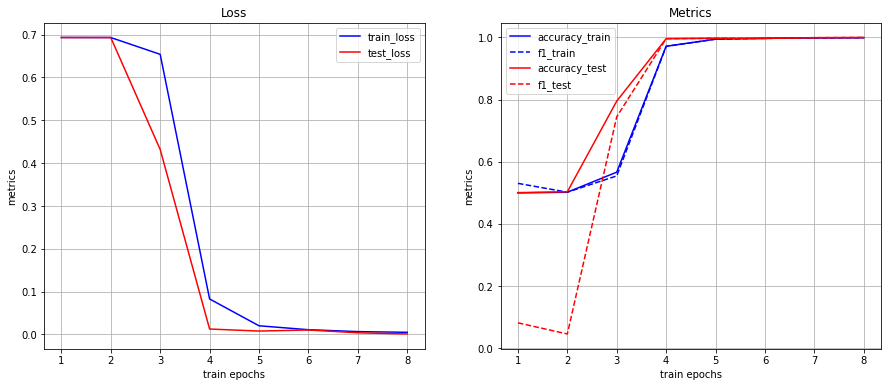

In [ ]:
train_loss = [el.cpu().detach().numpy() for el in experiment.dict_logging['train']['loss']][:8]
test_loss = [el.cpu().detach().numpy() for el in experiment.dict_logging['test']['loss']][:8]

train_accuracy = experiment.dict_logging['train']['accuracy'][:8]
train_f1 = experiment.dict_logging['train']['f1'][:8]
test_accuracy = experiment.dict_logging['test']['accuracy'][:8]
test_f1 = experiment.dict_logging['test']['f1'][:8]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(np.arange(len(test_accuracy))+1, train_loss, c='blue', label ='train_loss')
plt.plot(np.arange(len(test_accuracy))+1, test_loss, c='red', label ='test_loss')
plt.grid()
plt.legend()
plt.xlabel('train epochs')
plt.ylabel('metrics')


plt.subplot(1, 2, 2)
plt.title("Metrics")

plt.plot(np.arange(len(train_accuracy))+1, train_accuracy, c='blue', label ='accuracy_train')
plt.plot(np.arange(len(train_accuracy))+1, train_f1, c='blue', linestyle='--', label ='f1_train')
plt.plot(np.arange(len(test_accuracy))+1, test_accuracy, c='red', label ='accuracy_test')
plt.plot(np.arange(len(test_accuracy))+1, test_f1, c='red', linestyle='--', label ='f1_test')
plt.grid()
plt.legend()
plt.xlabel('train epochs')
plt.ylabel('metrics')


plt.show()

# Reg attack analysis

In [4]:
df_loc_test = pd.read_csv(f'results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/TEST_aa_res_Ford_A_0_alpha=1.csv', index_col=0)
df_loc_orig = pd.read_csv(f'results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/aa_res_Ford_A_0_alpha=1.csv', index_col=0)

In [42]:
models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'reg_disc_diff': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc/', 0),
    'reg_disc_diff_another': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/', 0),
    'reg_disc_diff_many_2':('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_many/', 0),
    'reg_disc_diff_many_4':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    'ITER_2':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2/', 0),
    'ITER_2_BIG_ALPHA':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2_BIG_ALPHA/', 0),
    'ITER_3':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_3/', 0),
    'iter_mix_3': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_iters_3/', 0),
    'iter_mix_2': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2/', 0),
    'iter_mix_2_big': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2_big/', 0),
    'iter_mix_2_12': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_12/', 0),
    'reg_disc_diff_many_4_id_1':('results/Ford_A/IFGSM/Disc_reg_model_id_1/', 1),
    'Many':('results/Ford_A/IFGSM/Disc_reg_10/', 0),
    'DeepFool':('results/Ford_A/DeepFool/Original/', 0),
    }

df_res = load_all_datasets(models_for_viz)
df_res['eps'] = df_res['eps'].round(4)

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 reg_disc_diff
Fail with Alpha 0 reg_disc_diff_another
Fail with Alpha 0 reg_disc_diff_many_2
Fail with Alpha 0 reg_disc_diff_many_4
Fail with Alpha 0 ITER_2
Fail with Alpha 0.001 ITER_2
Fail with Alpha 0.01 ITER_2
Fail with Alpha 0 ITER_2_BIG_ALPHA
Fail with Alpha 0.001 ITER_2_BIG_ALPHA
Fail with Alpha 0.01 ITER_2_BIG_ALPHA
Fail with Alpha 0 ITER_3
Fail with Alpha 0.001 ITER_3
Fail with Alpha 0.01 ITER_3
Fail with Alpha 0 iter_mix_3
Fail with Alpha 0.001 iter_mix_3
Fail with Alpha 0.01 iter_mix_3
Fail with Alpha 100 iter_mix_3
Fail with Alpha 0 iter_mix_2
Fail with Alpha 0.001 iter_mix_2
Fail with Alpha 0.01 iter_mix_2
Fail with Alpha 0.1 iter_mix_2
Fail with Alpha 100 iter_mix_2
Fail with Alpha 0 iter_mix_2_big
Fail with Alpha 0.001 iter_mix_2_big
Fail with Alpha 0.01 iter_mix_2_big
Fail with Alpha 0 iter_mix_2_12
Fail with Alpha 0.001 iter_mix_2_12
Fail with Alpha 0.01 iter_mix_2_12
Fail with Alpha 0 reg_di

In [43]:
#df_res['eps'].unique()

In [44]:
#df_res['method_attack'].unique()

In [45]:
alpha = 10
eps = df_res.eps.unique()[1]

print('eps: ', eps)
mask_alpha_eps = (df_res['eps'] == eps) & (df_res['alpha'].isin([0, alpha]))

df_filter = df_res[mask_alpha_eps]

eps:  0.0056


In [46]:
df_filter[]

,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.000766,0.0056,original,0.0
1,1,0.725758,0.725349,0.651178,0.000804,0.0056,original,0.0
2,2,0.687955,0.687148,0.616083,0.010366,0.0056,original,0.0
3,3,0.647500,0.646286,0.581283,0.132300,0.0056,original,0.0
4,4,0.607652,0.605987,0.550061,0.356830,0.0056,original,0.0
...,...,...,...,...,...,...,...,...
46,46,0.591061,0.577949,0.559672,0.712023,0.0056,DeepFool,0.0
47,47,0.590606,0.577490,0.559076,0.712276,0.0056,DeepFool,0.0
48,48,0.590152,0.577006,0.558768,0.713735,0.0056,DeepFool,0.0
49,49,0.589545,0.576389,0.558011,0.714244,0.0056,DeepFool,0.0


In [9]:
style ={
    'original':  {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    'reg_neigh':  {'linestyle':'solid', 'linewidth':1.5, 'color':'orange'},
    'reg_disc_same':  {'linestyle':'dotted', 'linewidth':1.5, 'color':'black'},
    #'reg_disc_diff':  {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    #'reg_disc_diff_another':  {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    #'reg_disc_diff_many_2': {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    'reg_disc_diff_many_4': {'linestyle':'dashed', 'linewidth':1.0,},
    'ITER_2': {'linestyle':'dashdot', 'linewidth':1.0, 'color':'green'},
    'ITER_2_BIG_ALPHA': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'green'},
    'ITER_3': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'blue'},
    'iter_mix_3': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'grey'},
    'iter_mix_2': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'black'},
    'iter_mix_2_big': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'red'},
    'iter_mix_2_12': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'purple'},
    'reg_disc_diff_many_4_id_1': {'linestyle':'dashed', 'linewidth':1.0, },
    'Many': {'linestyle':'solid', 'linewidth':1.5, 'color':'grey'},
    'DeepFool': {'linestyle':'dashed', 'linewidth':1.5, },
    
}

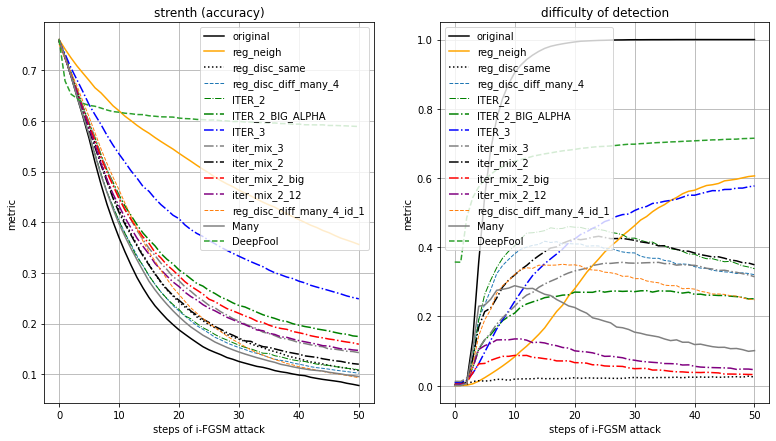

In [10]:
metrics = ['ACC', 'HID']

plt.figure(figsize=(5*len(metrics) + 3, 7))


for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    metric_name = 'strenth (accuracy)' if metric == 'ACC' else 'difficulty of detection'
    plt.title(metric_name)
    for method_attack in df_filter['method_attack'].unique():
        if method_attack not in style:
            continue
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack, 
                 **style[method_attack])

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()


### viz_mode

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 reg_disc_diff_1
Fail with Alpha 0 reg_disc_diff_2
Fail with Alpha 0 reg_disc_diff_4


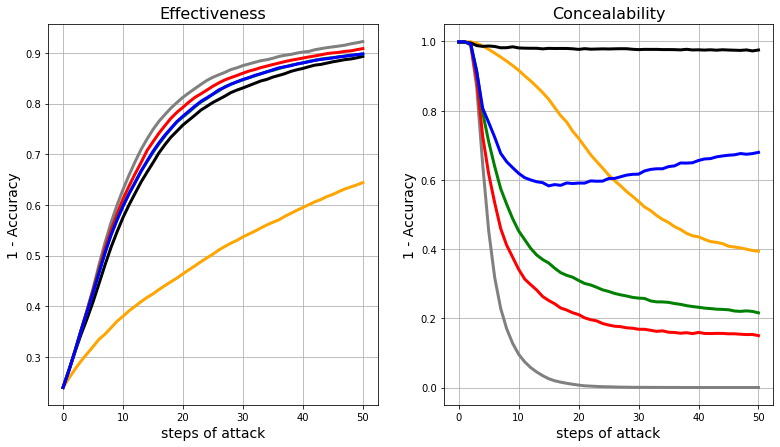

In [13]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]

models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    #'reg_disc_diff_another': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc/', 0),
    'reg_disc_diff_1': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/', 0),
    'reg_disc_diff_2':('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_many/', 0),
    'reg_disc_diff_4':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    }


style ={
    'original':  {'linestyle':'solid', 'linewidth':3.0, 'color':'grey'},
    'reg_neigh':  {'linestyle':'solid', 'linewidth':3.0, 'color':'orange'},
    'reg_disc_same':  {'linestyle':'solid', 'linewidth':3.0, 'color':'black'},
    #'reg_disc_diff_another':  {'linestyle':'solid', 'linewidth':1.5, },
    'reg_disc_diff_1':  {'linestyle':'solid', 'linewidth':3.0, 'color':'red'},
    'reg_disc_diff_2': {'linestyle':'solid', 'linewidth':3.0, 'color':'green'},
    'reg_disc_diff_4': {'linestyle':'solid', 'linewidth':3.0, 'color':'blue'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, legend=False, inverse=True)

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 reg_disc_diff_1
Fail with Alpha 0 reg_disc_diff_2
Fail with Alpha 0 reg_disc_diff_4


<Figure size 720x720 with 0 Axes>

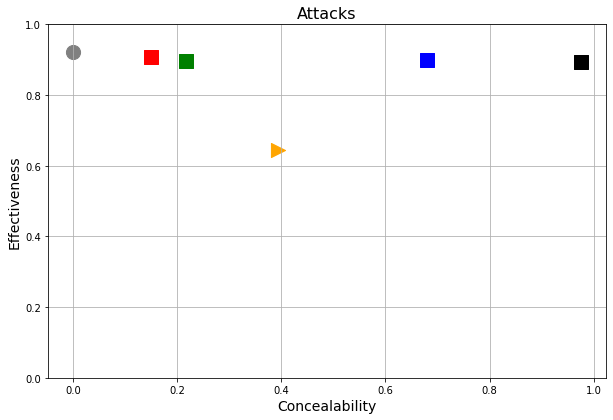

In [11]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]

models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    #'reg_disc_diff_another': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc/', 0),
    'reg_disc_diff_1': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/', 0),
    'reg_disc_diff_2':('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_many/', 0),
    'reg_disc_diff_4':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    }


style ={
    'original':  {'marker':'o', 's':200.0, 'color':'grey'},
    'reg_neigh':  {'marker':'>', 's':200.0, 'color':'orange'},
    'reg_disc_same':  {'marker':'s', 's':200.0, 'color':'black'},
    #'reg_disc_diff_another':  {'linestyle':'solid', 'linewidth':1.5, },
    'reg_disc_diff_1':  {'marker':'s', 's':200.0, 'color':'red'},
    'reg_disc_diff_2': {'marker':'s', 's':200.0, 'color':'green'},
    'reg_disc_diff_4': {'marker':'s', 's':200.0, 'color':'blue'},
}

plot_attack_scatter(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, legend=False, figsize=(10, 6.5))

Fail with Alpha 0 IFGSM
Fail with Alpha 0.001 IFGSM
Fail with Alpha 100 IFGSM
Fail with Alpha 0.001 SimBA
Fail with Alpha 0.01 SimBA
Fail with Alpha 0.1 SimBA
Fail with Alpha 1 SimBA
Fail with Alpha 10 SimBA
Fail with Alpha 100 SimBA
Fail with Alpha 0.001 DeepFool
Fail with Alpha 0.01 DeepFool


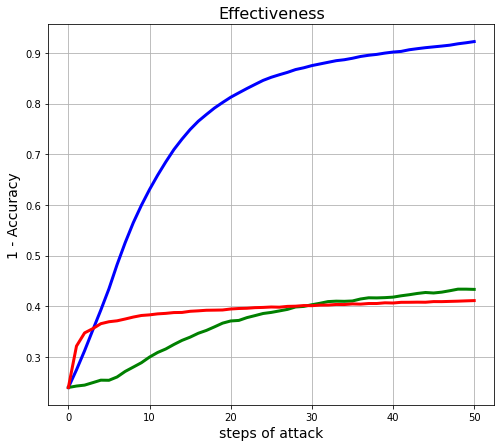

In [12]:
alpha = 10
eps = {
    'IFGSM': 0.0056,
    'SimBA':  0.1778,
    'DeepFool':  0.1778
}
metrics=['ACC']

models_for_viz = {
    'IFGSM': ('results/Ford_A/IFGSM/Original/', 0),
    'SimBA': ('results/Ford_A/SimBA/Original/', 0),
    'DeepFool': ('results/Ford_A/DeepFool/Original/', 0),
    }


style ={
    'IFGSM': {'linestyle':'solid', 'linewidth':3.0, 'color':'blue'},
    'SimBA': {'linestyle':'solid', 'linewidth':3.0, 'color':'green'},
    'DeepFool': {'linestyle':'solid', 'linewidth':3.0, 'color':'red'},
}



plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, metrics=metrics, legend=False, inverse=True)

# iterations

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 ITER_1
Fail with Alpha 0 ITER_2
Fail with Alpha 0.001 ITER_2
Fail with Alpha 0.01 ITER_2
Fail with Alpha 0 ITER_3
Fail with Alpha 0.001 ITER_3
Fail with Alpha 0.01 ITER_3
Fail with Alpha 0 best
Fail with Alpha 0.001 best
Fail with Alpha 0.01 best


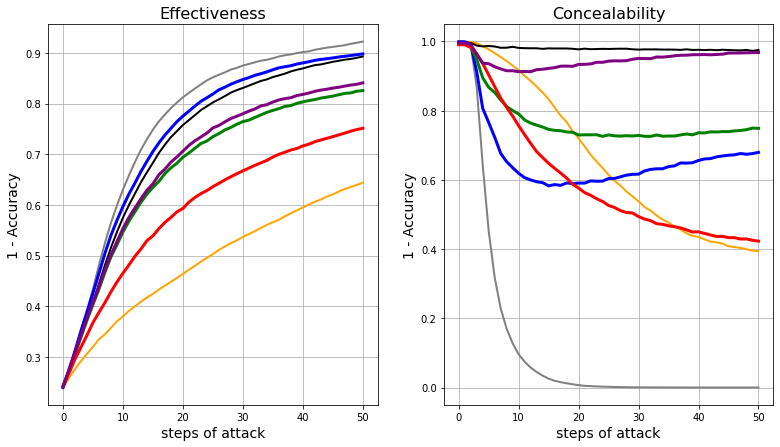

In [7]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]

models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'ITER_1':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    'ITER_2':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2_BIG_ALPHA/', 0),
    'ITER_3':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_3/', 0),
    'best': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2_big/', 0),
    }


style ={
    'original': {'linestyle':'solid', 'linewidth':2.0, 'color':'grey'},
    'reg_neigh': {'linestyle':'solid', 'linewidth':2.0, 'color':'orange'},
    'reg_disc_same': {'linestyle':'solid', 'linewidth':2.0, 'color':'black'},
    'ITER_1':{'linestyle':'solid', 'linewidth':3.0, 'color':'blue'},
    'ITER_2':{'linestyle':'solid', 'linewidth':3.0, 'color':'green'},
    'ITER_3':{'linestyle':'solid', 'linewidth':3.0, 'color':'red'},
    'best': {'linestyle':'solid', 'linewidth':3.0, 'color':'purple'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, legend=False, inverse=True)

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 ITER_1
Fail with Alpha 0 ITER_2
Fail with Alpha 0.001 ITER_2
Fail with Alpha 0.01 ITER_2
Fail with Alpha 0 ITER_3
Fail with Alpha 0.001 ITER_3
Fail with Alpha 0.01 ITER_3
Fail with Alpha 0 best
Fail with Alpha 0.001 best
Fail with Alpha 0.01 best


<Figure size 720x720 with 0 Axes>

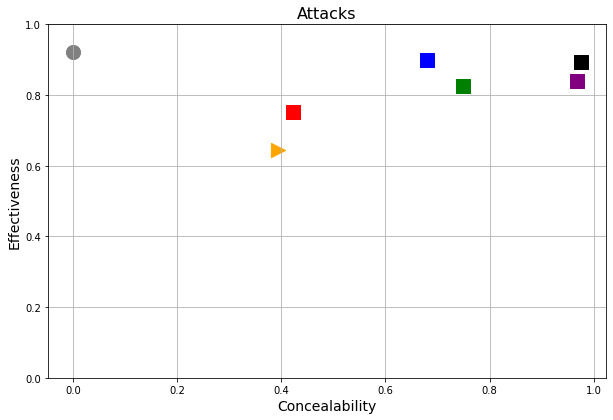

In [10]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]

models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'ITER_1':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    'ITER_2':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2_BIG_ALPHA/', 0),
    'ITER_3':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_3/', 0),
    'best': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2_big/', 0),
    }

style ={
    'original':  {'marker':'o', 's':200.0, 'color':'grey'},
    'reg_neigh':  {'marker':'>', 's':200.0, 'color':'orange'},
    'reg_disc_same':  {'marker':'s', 's':200.0, 'color':'black'},
    #'reg_disc_diff_another':  {'linestyle':'solid', 'linewidth':1.5, },
    'ITER_1':  {'marker':'s', 's':200.0, 'color':'blue'},
    'ITER_2': {'marker':'s', 's':200.0, 'color':'green'},
    'ITER_3': {'marker':'s', 's':200.0, 'color':'red'},
    'best': {'marker':'s', 's':200.0, 'color':'purple'},
}

plot_attack_scatter(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, legend=False, figsize=(10, 6.5))

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 ITER_1
Fail with Alpha 0 ITER_2
Fail with Alpha 0.001 ITER_2
Fail with Alpha 0.01 ITER_2
Fail with Alpha 0 ITER_3
Fail with Alpha 0.001 ITER_3
Fail with Alpha 0.01 ITER_3
Fail with Alpha 0 ITER_1_2
Fail with Alpha 0.001 ITER_1_2
Fail with Alpha 0.01 ITER_1_2
Fail with Alpha 0.1 ITER_1_2
Fail with Alpha 1 ITER_1_2
Fail with Alpha 100 ITER_1_2
Fail with Alpha 0 ITER_1_many
Fail with Alpha 0.001 ITER_1_many
Fail with Alpha 0.01 ITER_1_many
Fail with Alpha 0.1 ITER_1_many
Fail with Alpha 1 ITER_1_many
Fail with Alpha 100 ITER_1_many
Fail with Alpha 0 ITER_2_many
Fail with Alpha 0.001 ITER_2_many
Fail with Alpha 0.01 ITER_2_many
Fail with Alpha 0.1 ITER_2_many
Fail with Alpha 1 ITER_2_many
Fail with Alpha 100 ITER_2_many
Fail with Alpha 0 ITER_2_6
Fail with Alpha 0.001 ITER_2_6
Fail with Alpha 0.01 ITER_2_6
Fail with Alpha 0.1 ITER_2_6
Fail with Alpha 1 ITER_2_6
Fail with Alpha 100 ITER_2_6
Fail with Alpha 0 best


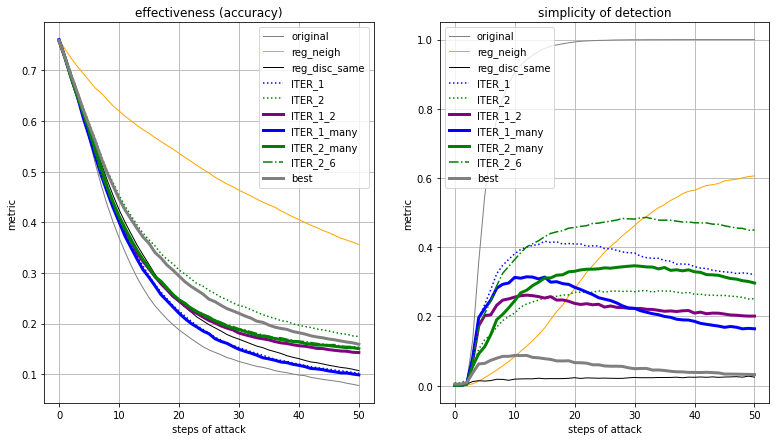

In [18]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]


models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'ITER_1':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    'ITER_2':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2_BIG_ALPHA/', 0),
    'ITER_3':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_3/', 0),
    #'ITER_1_2_many':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2_big/', 0),
    'ITER_1_2':('results/Ford_A/IFGSM/Regular_Disc/1_2_iter/', 0),
    'ITER_1_many':('results/Ford_A/IFGSM/Regular_Disc/8_2_models_iter_1/', 0),
    #'Many_2':('results/Ford_A/IFGSM/Regular_Disc/10_2_models_iter_1/', 0),
    'ITER_2_many':('results/Ford_A/IFGSM/Regular_Disc/8_2_models_iter_2/', 0),
    'ITER_2_6':('results/Ford_A/IFGSM/Regular_Disc/6_models_iter_2/', 0),
    #'Many':('results/Ford_A/IFGSM/Disc_reg_10/', 0),
    'best': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2_big/', 0),
    }


style ={
    'original': {'linestyle':'solid', 'linewidth':1.0, 'color':'grey'},
    'reg_neigh': {'linestyle':'solid', 'linewidth':1.0, 'color':'orange'},
    'reg_disc_same': {'linestyle':'solid', 'linewidth':1.0, 'color':'black'},
    'ITER_1':{'linestyle':'dotted', 'linewidth':1.5, 'color':'blue'},
    'ITER_2':{'linestyle':'dotted', 'linewidth':1.5, 'color':'green'},
    'ITER_2_6':{'linestyle':'dashdot', 'linewidth':1.5, 'color':'green'},
    #'ITER_3':{'linestyle':'solid', 'linewidth':2.0, 'color':'red'},
    'ITER_1_2':{'linestyle':'solid', 'linewidth':3.0, 'color':'purple'},
    'ITER_1_many':{'linestyle':'solid', 'linewidth':3.0, 'color':'blue'},
    'ITER_2_many':{'linestyle':'solid', 'linewidth':3.0, 'color':'green'},
    'Many' : {'linestyle':'dotted', 'linewidth':3.0, 'color':'yellow'},
    'Many_2' : {'linestyle':'solid', 'linewidth':3.0, 'color':'yellow'},
    'best': {'linestyle':'solid', 'linewidth':3.0, 'color':'grey'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps)

Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 reg_disc
Fail with Alpha 0.001 reg_disc
Fail with Alpha 0.01 reg_disc


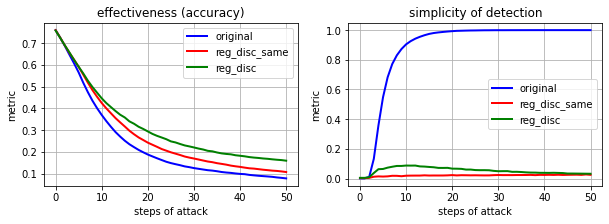

In [9]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]


models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    #'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'reg_disc': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2_big/', 0),
    #'reg_disc_best_2': ('results/Ford_A/IFGSM/Regular_Disc/18_discrim/', 0),
    }


style ={
    'original': {'linestyle':'solid', 'linewidth':2.0, 'color':'blue'},
    'reg_neigh': {'linestyle':'solid', 'linewidth':1.0, 'color':'orange'},
    'reg_disc_same': {'linestyle':'solid', 'linewidth':2.0, 'color':'red'},
    'reg_disc': {'linestyle':'solid', 'linewidth':2.0, 'color':'green'},
    #'reg_disc_best_2': {'linestyle':'solid', 'linewidth':1.0, 'color':'red'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, figsize=(10, 3))

Fail with Alpha 0 attack 1
Fail with Alpha 0 attack 2


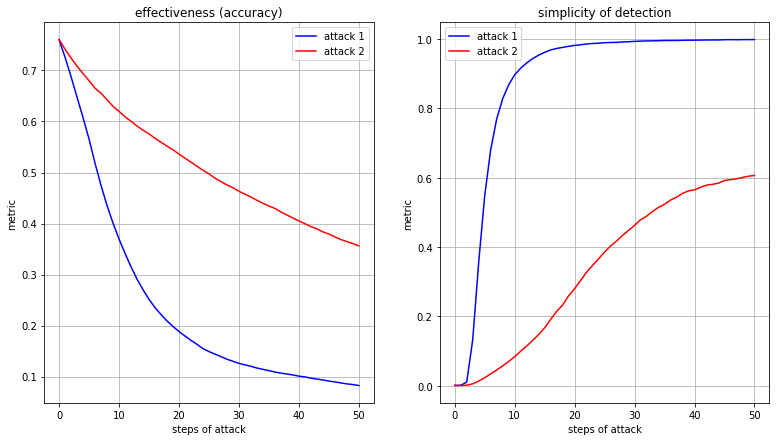

In [26]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]

models_for_viz = {
    'attack 1': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc/', 0),
    'attack 2': ('results/Ford_A/IFGSM/Regular/', 0),
    }


style ={
    'attack 1':  {'linestyle':'solid', 'linewidth':1.5, 'color':'blue'},
    'attack 2': {'linestyle':'solid', 'linewidth':1.5, 'color':'red'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps)

# another oracle

Fail with Alpha 0 reg_disc_1
Fail with Alpha 0.001 reg_disc_1
Fail with Alpha 0.01 reg_disc_1
Fail with Alpha 0 reg_disc_2
Fail with Alpha 0.001 reg_disc_2
Fail with Alpha 0.01 reg_disc_2
Fail with Alpha 0.1 reg_disc_2
Fail with Alpha 1 reg_disc_2
Fail with Alpha 100 reg_disc_2
Fail with Alpha 0 reg_disc_3
Fail with Alpha 0.001 reg_disc_3
Fail with Alpha 0.01 reg_disc_3
Fail with Alpha 0.1 reg_disc_3
Fail with Alpha 1 reg_disc_3
Fail with Alpha 100 reg_disc_3


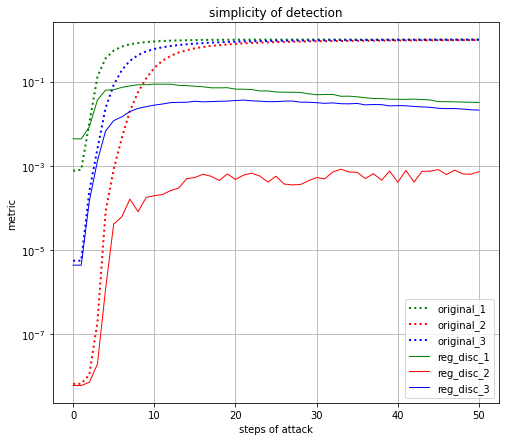

In [23]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]


models_for_viz = {
    'original_1': ('results/Ford_A/IFGSM/Original/', 0),
    'original_2': ('results/Ford_A/IFGSM/Regular_Disc/original_id_1/', 0),
    'original_3': ('results/Ford_A/IFGSM/Regular_Disc/original_id_3/', 0),
    # 'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    # 'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'reg_disc_1': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2_big/', 0),
    'reg_disc_2': ('results/Ford_A/IFGSM/Regular_Disc/14_discrim_id_1/', 0),
    'reg_disc_3': ('results/Ford_A/IFGSM/Regular_Disc/14_discrim_id_3/', 0),
    }


style ={
    'original_1': {'linestyle':'dotted', 'linewidth':2.0, 'color':'green'},
    'original_2': {'linestyle':'dotted', 'linewidth':2.0, 'color':'red'},
    'original_3': {'linestyle':'dotted', 'linewidth':2.0, 'color':'blue'},
    'reg_neigh': {'linestyle':'dotted', 'linewidth':1.0, 'color':'orange'},
    'reg_disc_same': {'linestyle':'solid', 'linewidth':1.0, 'color':'black'},
    'reg_disc_1': {'linestyle':'solid', 'linewidth':1.0, 'color':'green'},
    'reg_disc_2': {'linestyle':'solid', 'linewidth':1.0, 'color':'red'},
    'reg_disc_3': {'linestyle':'solid', 'linewidth':1.0, 'color':'blue'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, metrics=['HID'], y_disc_log=True)

# IFGSM old plot

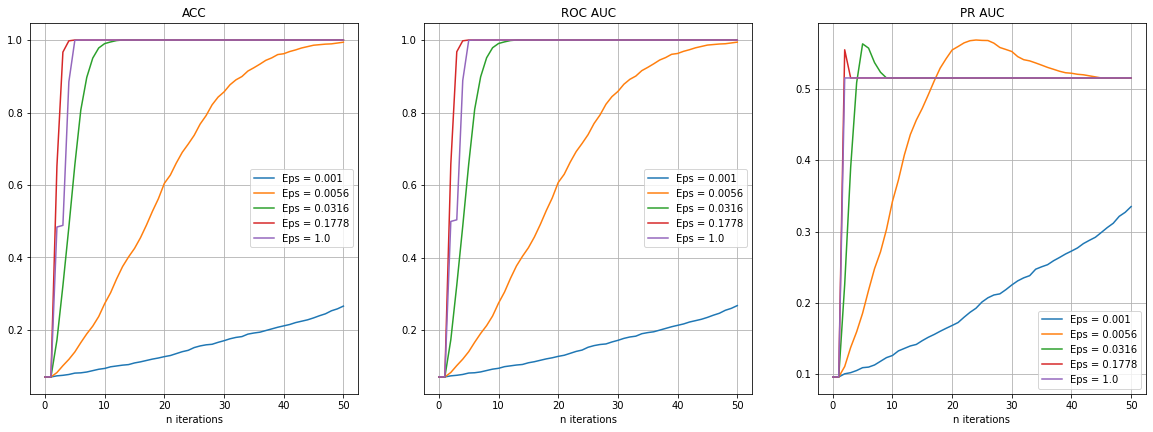

In [10]:
aa_res_df = pd.read_csv(f'results/TS2Vec/UCR/aa_res_FordA_0.csv', index_col=0)
plot_aa_metrics(aa_res_df, method='metric', inverse=True)

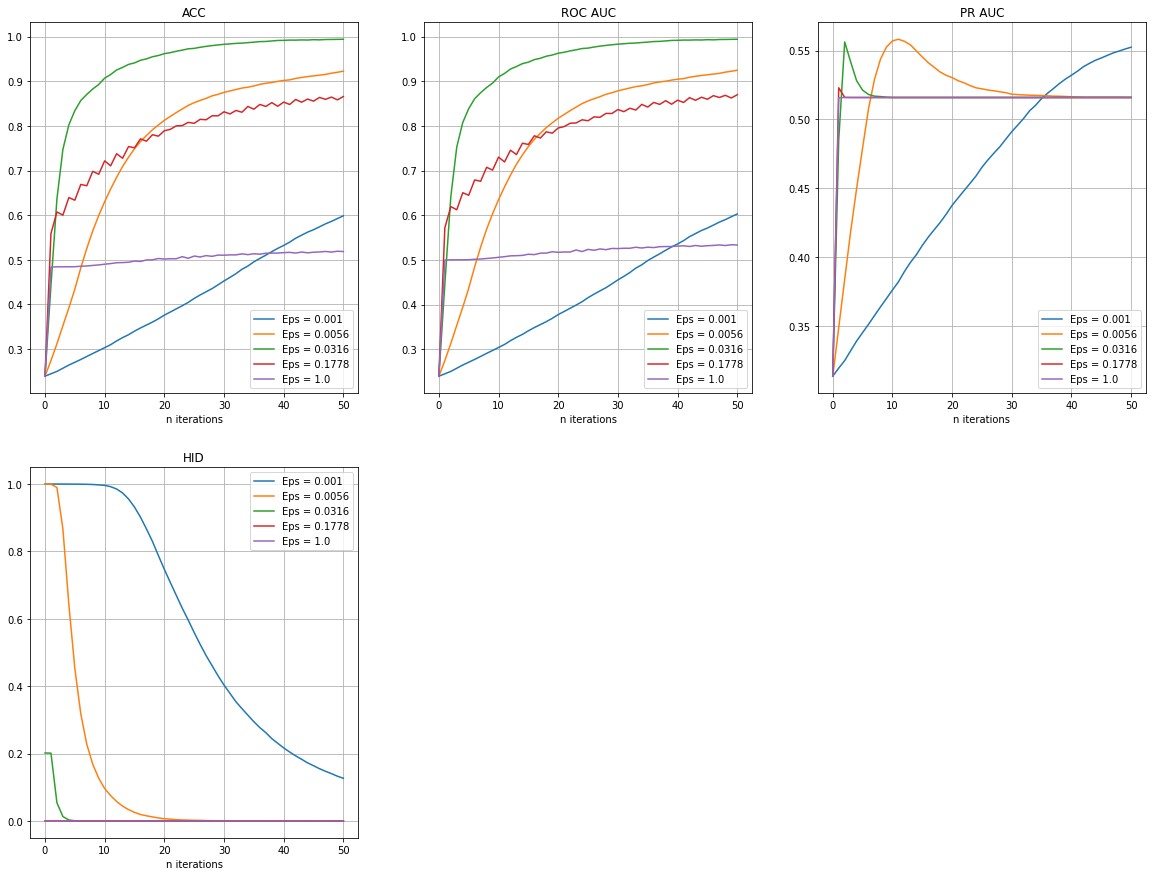

In [11]:
aa_res_df= pd.read_csv(f'results/Ford_A/IFGSM/Original/aa_res_Ford_A_0_alpha=0.1.csv', index_col=0)
plot_aa_metrics(aa_res_df, method='metric', inverse=True)

# DeepFool

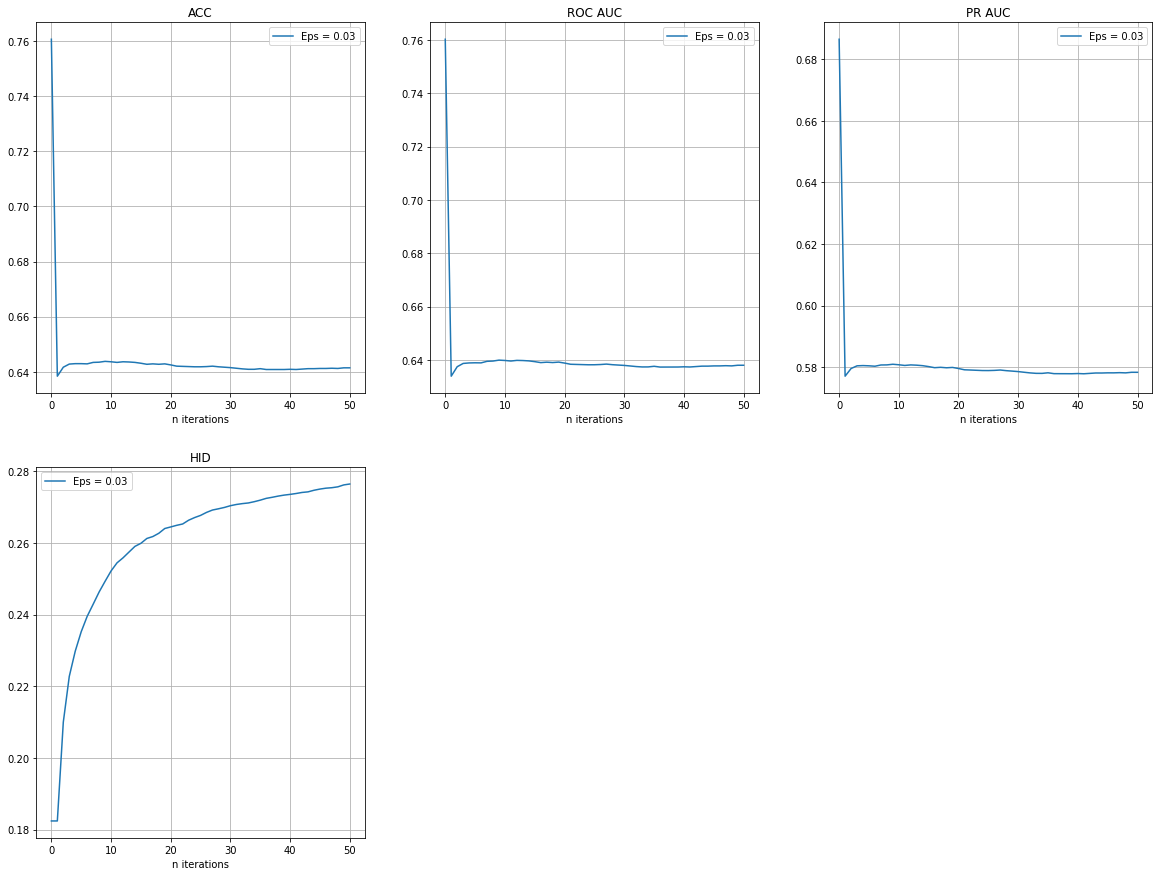

In [8]:
aa_res_df= pd.read_csv(f'results/Ford_A/DeepFool/DEBUG2_deepfool_attack/aa_res_Ford_A_0.csv', index_col=0)
plot_aa_metrics(aa_res_df, method='metric')

# SimBA

In [5]:
models_for_viz = {
    'original': ('results/Ford_A/SimBA/Original/', 0),
    'reg_neigh': ('results/Ford_A/SimBA/Regular/', 0),
    'reg_disc_diff_many':('results/Ford_A/SimBA/Regular_Disc_diff_many/', 0),
}

df_res = load_all_datasets(models_for_viz)

FileNotFoundError: [Errno 2] No such file or directory: 'results/Ford_A/SimBA/Original/aa_res_Ford_A_0.csv'

In [ ]:
alpha = 1
eps = df_res.eps.unique()[3]
print('eps: ', eps)
mask_alpha_eps = (df_res['eps'] == eps) & (df_res['alpha'].isin([0, alpha]))

df_filter = df_res[mask_alpha_eps]
df_filter

eps:  0.1778279410038923


,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.477916,0.177828,reg_neigh,1.0
1,1,0.760303,0.760022,0.686133,0.477042,0.177828,reg_neigh,1.0
2,2,0.758561,0.758149,0.684759,0.731079,0.177828,reg_neigh,1.0
3,3,0.752121,0.751667,0.678126,0.841884,0.177828,reg_neigh,1.0
4,4,0.748636,0.748329,0.674010,0.907068,0.177828,reg_neigh,1.0
...,...,...,...,...,...,...,...,...
46,46,0.574924,0.572812,0.526795,0.997965,0.177828,reg_disc_diff_many,1.0
47,47,0.571667,0.569582,0.524619,0.997963,0.177828,reg_disc_diff_many,1.0
48,48,0.570076,0.568055,0.523580,0.998031,0.177828,reg_disc_diff_many,1.0
49,49,0.568864,0.566851,0.522782,0.998081,0.177828,reg_disc_diff_many,1.0


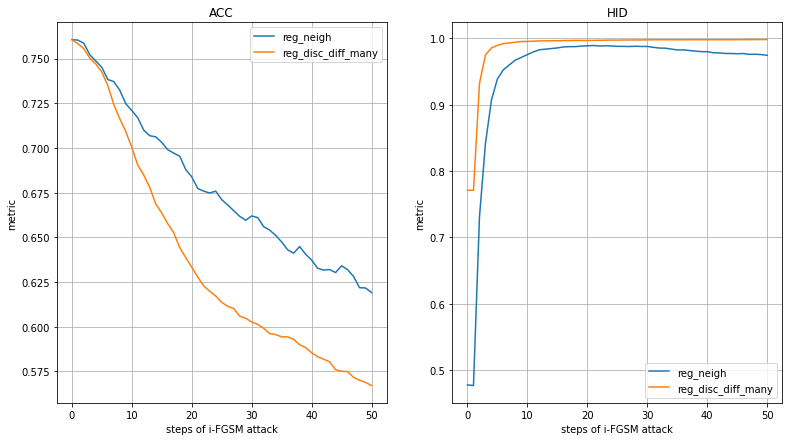

In [ ]:
metrics = ['ACC', 'HID']

plt.figure(figsize=(5*len(metrics) + 3, 7))


for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    plt.title(metric)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()


# Coffee

Fail with Alpha 0 reg_neigh
Fail with Alpha 0.001 reg_neigh
Fail with Alpha 0.1 reg_neigh
Fail with Alpha 0 reg_disc
Fail with Alpha 0.001 reg_disc
Fail with Alpha 0.1 reg_disc


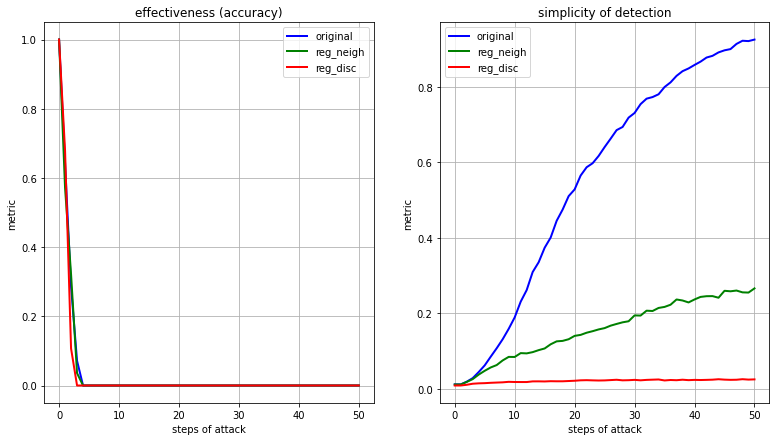

In [11]:
alpha = 10
eps = 0.13 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]
dataset = 'Coffee'


alpha ={
    'original':0,
    'reg_neigh':0.01,
    'reg_disc':10,
}


models_for_viz = {
    'original': ('results/Coffee/IFGSM/DEBUG_fgsm_attack/', 0),
    'reg_neigh': ('results/Coffee/IFGSM/DEBUG_fgsm_reg_attack/', 0),
    'reg_disc': ('results/Coffee/IFGSM/DEBUG_fgsm_disc_attack/', 0),
    }

style ={
    'original':{'linestyle':'solid', 'linewidth':2.0, 'color':'blue'},
    'reg_neigh':{'linestyle':'solid', 'linewidth':2.0, 'color':'green'},
    'reg_disc':{'linestyle':'solid', 'linewidth':2.0, 'color':'red'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, dataset=dataset)

# Strawberry

Fail with Alpha 0 reg_neigh
Fail with Alpha 0.001 reg_neigh
Fail with Alpha 0.01 reg_neigh
Fail with Alpha 0 reg_disc
Fail with Alpha 0.001 reg_disc
Fail with Alpha 0.01 reg_disc
Fail with Alpha 0.1 reg_disc
Fail with Alpha 1 reg_disc
Fail with Alpha 100 reg_disc


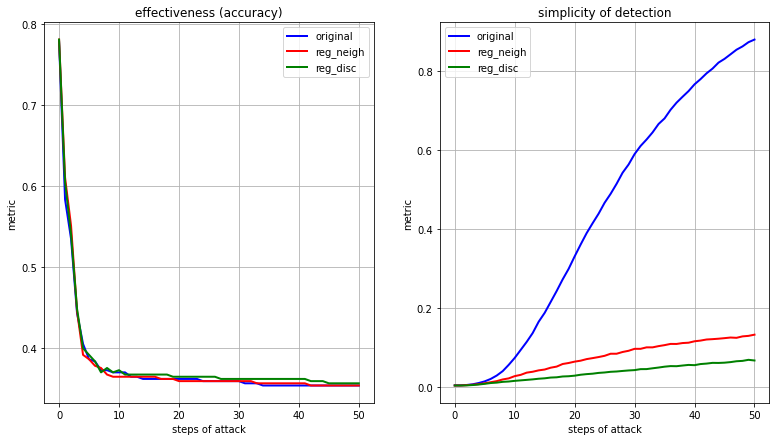

In [7]:
alpha = 10
eps = 0.0316 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]
dataset = 'Strawberry'

alpha ={
    'original':0,
    'reg_neigh':0.1,
    'reg_disc':10,
}

models_for_viz = {
    #'original': (f'results/{dataset}/IFGSM/Original/', 0),
    'original': (f'results/{dataset}/IFGSM/Original_test_3/', 0),
    'reg_neigh': (f'results/{dataset}/IFGSM/Regular_test_3/', 0),
    #'reg_disc': (f'results/{dataset}/IFGSM/Regular_disc_test_3/', 0),
    'reg_disc': (f'results/{dataset}/IFGSM/New3_fgsm_disc_attack/', 0),
    }

style ={
    'original':{'linestyle':'solid', 'linewidth':2.0, 'color':'blue'},
    'reg_neigh': {'linestyle':'solid', 'linewidth':2.0, 'color':'red'},
    'reg_disc': {'linestyle':'solid', 'linewidth':2.0, 'color':'green'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, dataset=dataset)

# FordA TS2vec

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc
Fail with Alpha 0.001 reg_disc
Fail with Alpha 0.01 reg_disc
Fail with Alpha 0.1 reg_disc
Fail with Alpha 1 reg_disc
Fail with Alpha 100 reg_disc


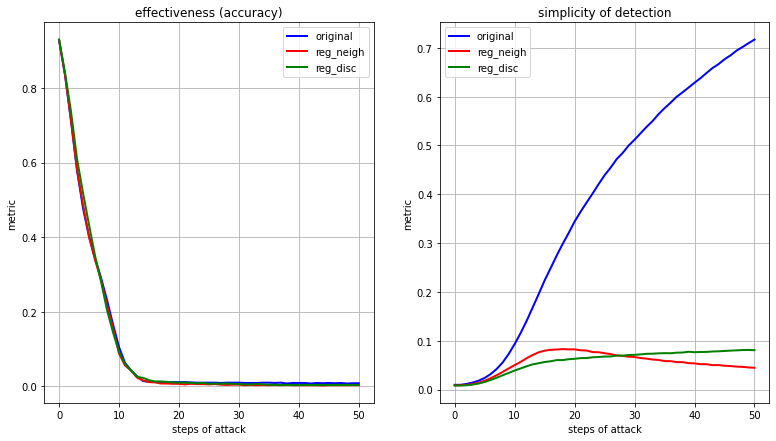

In [9]:
alpha = 10
eps =  0.0316 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]
dataset = 'FordA'


alpha ={
    'original':0,
    'reg_neigh':0.01,
    'reg_disc':10,
    'reg_disc_many':10,
}

models_for_viz = {
    'original': (f'results/{dataset}/IFGSM/New_fgsm_attack/', 0),
    'reg_neigh': (f'results/{dataset}/IFGSM/New_fgsm_reg_attack/', 0),
    'reg_disc': (f'results/{dataset}/IFGSM/Many_fgsm_disc_attack/', 0),
    #'reg_disc_10': (f'results/{dataset}/IFGSM/Many_fgsm_disc_attack/', 0),
    }

style ={
    'original':{'linestyle':'solid', 'linewidth':2.0, 'color':'blue'},
    'reg_neigh': {'linestyle':'solid', 'linewidth':2.0, 'color':'red'},
    'reg_disc': {'linestyle':'solid', 'linewidth':2.0, 'color':'green'},
    'reg_disc_many': {'linestyle':'solid', 'linewidth':2.0, 'color':'black'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, dataset=dataset)

# FordB

Fail with Alpha 0 reg_neigh
Fail with Alpha 0.001 reg_neigh
Fail with Alpha 0.1 reg_neigh
Fail with Alpha 0 reg_disc
Fail with Alpha 0.001 reg_disc
Fail with Alpha 0.01 reg_disc
Fail with Alpha 0.1 reg_disc


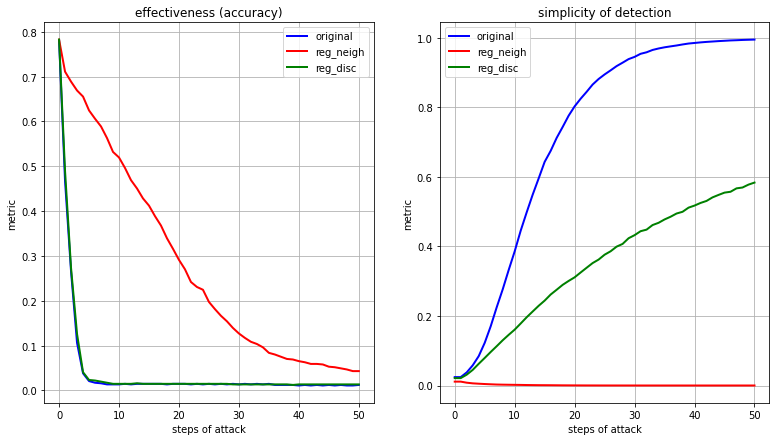

In [26]:
alpha = 10
eps = 0.07 # [0.001, 0.0056, 0.0316, 0.1778, 1.0] [0.03, 0.07, 0.01, 0.13, 0.17]
dataset = 'FordB'

models_for_viz = {
    #'original': (f'results/{dataset}/IFGSM/Original/', 0),
    'original': (f'results/{dataset}/IFGSM/DEBUG_fgsm_attack/', 0),
    'reg_neigh': (f'results/{dataset}/IFGSM/DEBUG_fgsm_reg_attack/', 0),
    'reg_disc': (f'results/{dataset}/IFGSM/DEBUG_fgsm_disc_attack/', 0),
    }

style ={
    'original':{'linestyle':'solid', 'linewidth':2.0, 'color':'blue'},
    'reg_neigh': {'linestyle':'solid', 'linewidth':2.0, 'color':'red'},
    'reg_disc': {'linestyle':'solid', 'linewidth':2.0, 'color':'green'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, dataset=dataset)

In [ ]:
table_results

## Hidennes of adversarial attack

In [ ]:
df_res.eps.unique()[[1]]

array([0.0056])

reg_disc_same


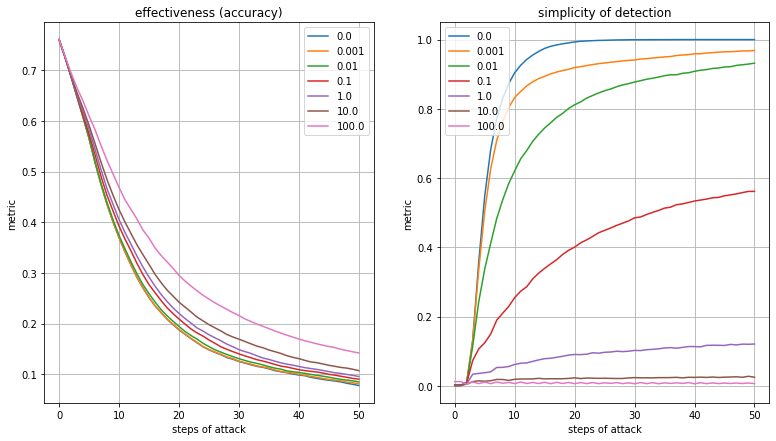

In [ ]:
metrics = ['ACC', 'HID']

eps = df_res.eps.unique()[[1]]
methods = ['reg_disc_same', 'original']

mask = (df_res['eps'].isin(eps)) & (df_res['method_attack'].isin(methods))

df_filter = df_res[mask]

print(methods[0])

plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)

    metric_name = 'effectiveness (accuracy)' if metric == 'ACC' else 'simplicity of detection'
    plt.title(metric_name)
    for alpha in sorted(df_filter['alpha'].unique()):
        df_filter_viz = df_filter[df_filter['alpha'] == alpha]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=alpha)

    plt.xlabel('steps of attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

reg_neigh


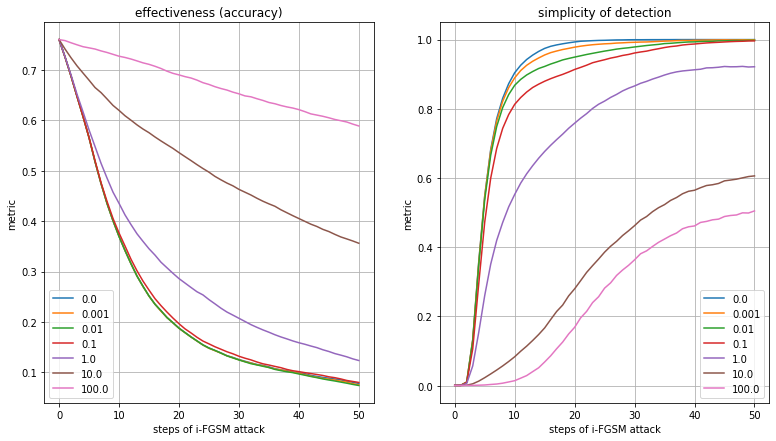

In [ ]:
metrics = ['ACC', 'HID']

eps = df_res.eps.unique()[[1]]
methods = ['reg_neigh', 'original']
print(methods[0])

mask = (df_res['eps'].isin(eps)) & (df_res['method_attack'].isin(methods))

df_filter = df_res[mask]

plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)

    metric_name = 'effectiveness (accuracy)' if metric == 'ACC' else 'simplicity of detection'
    plt.title(metric_name)
    for alpha in sorted(df_filter['alpha'].unique()):
        df_filter_viz = df_filter[df_filter['alpha'] == alpha]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=alpha)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

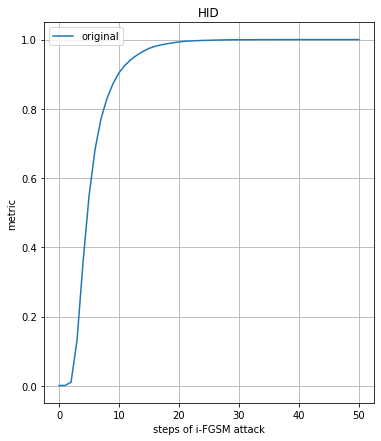

In [ ]:
metrics = ['ACC', 'HID']


plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, alpha in enumerate(df_filter['alpha'].unique()):
    plt.subplot(1, len(metrics), i+1)
    plt.title(metric)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

# Data Visualization

In [1]:
import copy
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

from models.models import LSTM_net, TS2VecClassifier
from utils.data import load_Ford_A, transform_data, MyDataset
from utils.attacks import fgsm_attack, fgsm_disc_attack
from utils.config import load_disc_config
from utils.utils import load_disc_model
from utils.TS2Vec.datautils import load_UCR


from utils.discrim_training import HideAttackExp

from utils.attacks import (fgsm_disc_attack, fgsm_attack, fgsm_reg_attack, 
simba_binary, simba_binary_reg, simba_binary_disc_reg, reg_disc)



## load attack params

In [2]:
def fgsm_attack(model, loss_func, x, y_true, eps):

    y_pred = model(x)
    y_pred = y_pred.flatten()

    loss_val = loss_func(y_pred, y_true)

    grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
    #print('fgsm_grad', torch.linalg.norm(grad_))
    x_adv = x.data + eps * torch.sign(grad_)

    return x_adv


def fgsm_disc_attack(model, loss_func, x, y_true, eps, alpha, disc_models, train_mode=False):

    y_pred = model(x)
    y_pred = y_pred.flatten()
    
    loss_val = loss_func(y_pred, y_true)
    grad_loss = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
    reg_value = reg_disc(x, alpha, disc_models, train_mode)
    grad_reg = torch.autograd.grad(reg_value, x, retain_graph=True)[0]
    grad_ = grad_loss - grad_reg
    x_adv = x.data + eps * torch.sign(grad_)
    return x_adv

def fgsm_reg_attack(model, loss_func, x, y_true, eps, alpha):

    y_pred = model(x)
    y_pred = y_pred.flatten()
    loss_val = loss_func(y_pred, y_true)
    reg_value = reg_neigh(x, alpha)

    loss = loss_val - reg_value
    grad_ = torch.autograd.grad(loss, x, retain_graph=True)[0]
    x_adv = x.data + eps * (torch.sign(grad_))

    return x_adv

def reg_neigh(x, alpha):
            
    x.requires_grad = True
    x_anchor = x[:, 1:-1]
    x_left = x[:, 2:]
    x_right = x[:, :-2]
    x_regular = (x_left + x_right) / 2
    reg_value = torch.sum((x_anchor - x_regular.detach()) ** 2, dim=list(range(1, len(x.shape))))
    reg_value = alpha * torch.mean(reg_value)
    return reg_value


def reg_disc(x, alpha: float, disc_models, train_mode=False):
    n_models = len(disc_models)
    reg_value = 0
    for d_model in disc_models:
        d_model.train(train_mode)
        req_grad(d_model, state=True)
        model_output = torch.mean(torch.log(F.sigmoid(d_model(x))))
        #print(torch.mean(d_model(x)))
        # #print(x.shape)
        reg_value = reg_value + model_output

    reg_value = alpha* reg_value / n_models
    return reg_value

def req_grad(model, state: bool = True) -> None:
    for param in model.parameters():
        param.requires_grad_(state)

## TS2Vec

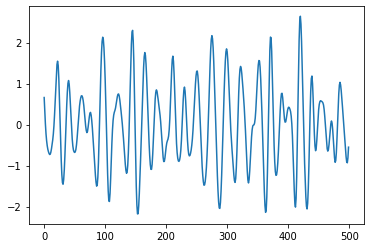

In [39]:
dataset_name = 'FordA'

cfg = {
    'model_folder':f'checkpoints/TS2Vec/entire_model/UCR/{dataset_name}/',
    'model_id_attack': 0,
    'disc_path': f'results/{dataset_name}/IFGSM/Discriminator_pickle',
    'disc_check_params': {'model_id' : 0, 'model_name': 'fgsm_attack_new_eps=0.13_nsteps=10'},

    'list_reg_model_params': [
        {'model_id':0, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.0001_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.001_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.0001_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.001_nsteps=10'},
        {'model_id':2, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.0001_nsteps=10'},
        {'model_id':2, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.001_nsteps=10'},
        {'model_id':3, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.0001_nsteps=10'},
        {'model_id':3, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.001_nsteps=10'},
        {'model_id':4, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.0001_nsteps=10'},
        {'model_id':4, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.001_nsteps=10'},
    ]
}

X_train, y_train, X_test, y_test = load_UCR(dataset_name)
X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test, slice_data=False)

device = 'cuda:1'
loss_func = torch.nn.BCELoss()

attack_model = TS2VecClassifier(dropout = 'None').to(device)
disc_model = TS2VecClassifier(dropout=0.0, device=2, n_layers=2).to(device)
disc_model.eval()

model_path = cfg['model_folder'] + f'model_{cfg["model_id_attack"]}_{dataset_name}.pth'
attack_model.load_state_dict(copy.deepcopy(torch.load(model_path)))
attack_model.eval()

discriminator = load_disc_model(
        copy.deepcopy(disc_model),
        model_id=cfg['disc_check_params']['model_id'], 
        path=cfg['disc_path'], 
        model_name=cfg['disc_check_params']['model_name'], 
        device=device
        )
discriminator.eval()

index = 5
original_object = X_test[index].unsqueeze(0)
plt.plot(original_object[0])

x = copy.deepcopy(original_object).unsqueeze(-1).to(device)
y = y_test[index].unsqueeze(0).to(torch.float).to(device)

disc_model = TS2VecClassifier(dropout=0.0, device=2, n_layers=2).to(device)
disc_models = load_disc_config(copy.deepcopy(disc_model), cfg['disc_path'], device, cfg['list_reg_model_params'])  
#disc_models = [model.eval() for model in disc_models]

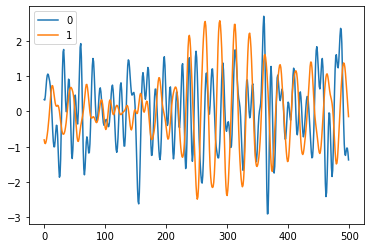

In [40]:
original_object = X_test[index].unsqueeze(0)
plt.plot(X_test[1].unsqueeze(0)[0], label='0')
plt.plot(X_test[25].unsqueeze(0)[0], label='1')
plt.legend()

In [41]:
def plot_attack(original_object, x_attack, x_reg_attack, x_disc_attack, y, attack_model, discriminator, iter_='', window=50):

        plt.figure(figsize=(18, 6))
        plt.title(str(iter_))
        label = y.item()
        hid_orig = round(discriminator(x).item(), 3)

        pred = round(attack_model(x_attack).item(), 3)
        hid_pred = round(discriminator(x_attack).item(), 3)
        plt.subplot(1, 3, 1)
        plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
        plt.plot(x_attack.cpu().detach().flatten()[:window], 
                label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
        plt.legend()
        plt.xlabel('Original attack')
        plt.grid()

        plt.subplot(1, 3, 2)

        pred = round(attack_model(x_reg_attack).item(), 3)
        hid_pred = round(discriminator(x_reg_attack).item(), 3)
        plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
        plt.plot(x_reg_attack.cpu().detach().flatten()[:window], 
                label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
        plt.legend()
        plt.grid()
        plt.xlabel('Regularized neighbour attack')

        plt.subplot(1, 3, 3)
        pred = round(attack_model(x_disc_attack).item(), 3)
        hid_pred = round(discriminator(x_disc_attack).item(), 3)
        plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
        plt.plot(x_disc_attack.cpu().detach().flatten()[:window], 
                label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
        plt.legend()
        plt.grid()
        plt.xlabel('Regularized discriminator attack')

        plt.show()

In [44]:
n_iterations = 10
eps = 0.13
alpha_reg = 1
alpha_disc = 10

x_attack = copy.deepcopy(x)
x_reg_attack = copy.deepcopy(x)
x_disc_attack = copy.deepcopy(x)



for iter_ in tqdm(range(n_iterations)):
    #print(iter_)

    x_attack.grad = None
    x_attack.requires_grad = True

    x_reg_attack.grad = None
    x_reg_attack.requires_grad = True

    x_disc_attack.grad = None
    x_disc_attack.requires_grad = True

    x_attack = fgsm_attack(attack_model, loss_func, x_attack, y, eps)
    x_reg_attack = fgsm_reg_attack(attack_model, loss_func, x_reg_attack, y, eps, alpha_reg)
    x_disc_attack = fgsm_disc_attack(attack_model, loss_func, x_disc_attack, y, eps, alpha_disc, disc_models)

    if iter_ % 1 == 0:
        print(discriminator(x_attack).item(), discriminator(x_disc_attack).item(),)
    #     plot_attack(original_object, x_attack, x_reg_attack, x_disc_attack, y, attack_model, discriminator, iter_=iter_)

  0%|          | 0/10 [00:00<?, ?it/s]

0.024975715205073357 0.011260428465902805
0.1571417897939682 0.04040999338030815
0.5870575308799744 0.06142807379364967
0.9566258192062378 0.4138849675655365
0.9872699975967407 0.3091370165348053
0.9968498349189758 0.4440773129463196
0.9988008737564087 0.41171109676361084
0.99959796667099 0.6165567636489868
0.999754011631012 0.547315239906311
0.9999109506607056 0.7168574333190918


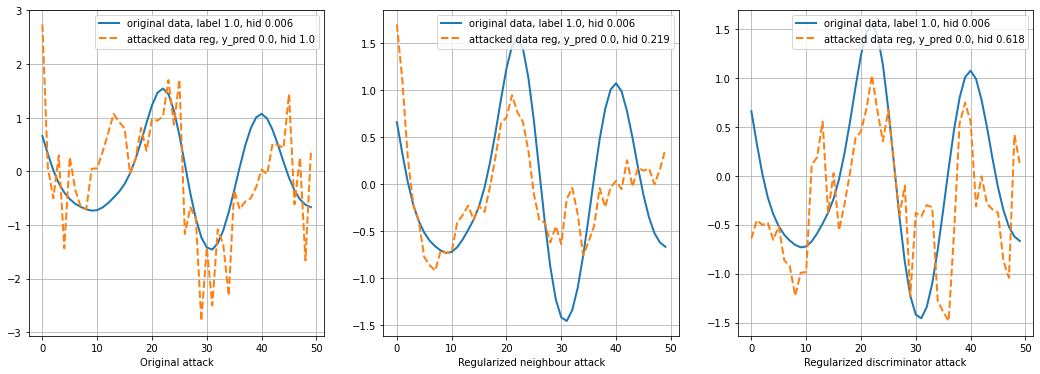

In [34]:
plot_attack(original_object, x_attack, x_reg_attack, x_disc_attack, y, attack_model, discriminator)

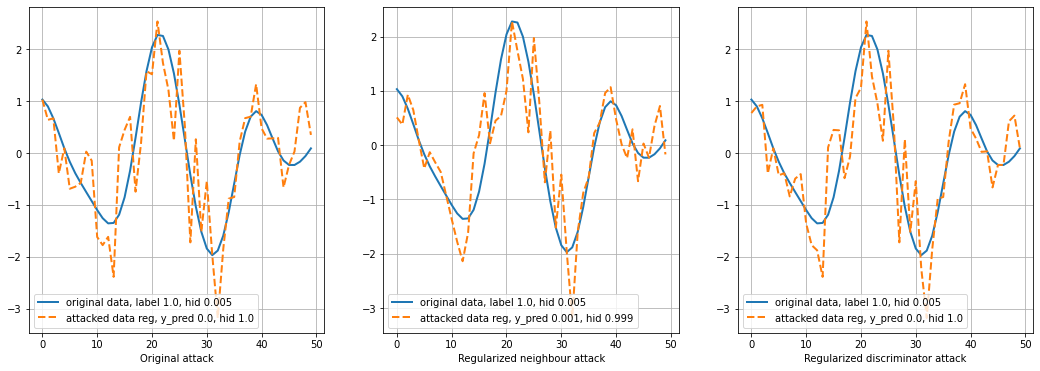

In [23]:
plt.figure(figsize=(18, 6))

window = 50
label = y.item()
hid_orig = round(discriminator(x).item(), 3)

plt.subplot(1, 3, 1)

pred = round(attack_model(x_attack).item(), 3)
hid_pred = round(discriminator(x_attack).item(), 3)
plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_attack.cpu().detach().flatten()[:window], 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
plt.legend()
plt.xlabel('Original attack')
plt.grid()

plt.subplot(1, 3, 2)

pred = round(attack_model(x_reg_attack).item(), 3)
hid_pred = round(discriminator(x_reg_attack).item(), 3)
plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_reg_attack.cpu().detach().flatten()[:window], 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('Regularized neighbour attack')

plt.subplot(1, 3, 3)
pred = round(attack_model(x_disc_attack).item(), 3)
hid_pred = round(discriminator(x_disc_attack).item(), 3)
plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_disc_attack.cpu().detach().flatten()[:window], 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('Regularized discriminator attack')


plt.show()

## Ford_A, LSTM

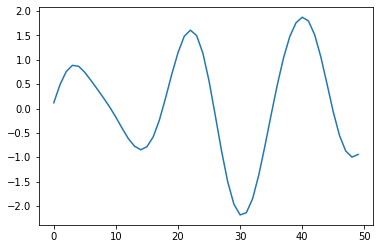

In [10]:
cfg = {
    'model_folder':'checkpoints/LSTM/Ford_A/',
    'model_id_attack': 0,
    'disc_path': 'results/Ford_A/IFGSM/Discriminator_pickle',
    'list_reg_model_params': [
        {'model_id':0, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.1_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.1_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_disc_attack_eps=0.03_alpha=0.01_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_disc_attack_eps=0.03_alpha=0.1_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_disc_attack_eps=0.03_alpha=0.01_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_disc_attack_eps=0.03_alpha=0.1_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=10_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=10_nsteps=10'},
        {'model_id':2, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10'},
        {'model_id':2, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=10_nsteps=10'},
     ],
    'disc_check_params': {'model_id' : 0, 'model_name': 'fgsm_attack_eps=0.03_nsteps=10'}
}

dataset_name = 'Ford_A'

X_train, X_test, y_train, y_test = load_Ford_A()
X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test)

device = 'cuda:1'
loss_func = torch.nn.BCELoss()

model = LSTM_net(hidden_dim = 50, n_layers = 1, output_dim = 1, dropout=0.0).to(device)
model_path = cfg['model_folder'] + f'model_{cfg["model_id_attack"]}_Ford_A.pth'
model.load_state_dict(copy.deepcopy(torch.load(model_path)))
model = model.train()

discriminator = load_disc_model(
        copy.deepcopy(model),
        model_id=cfg['disc_check_params']['model_id'], 
        path=cfg['disc_path'], 
        model_name=cfg['disc_check_params']['model_name'], 
        device=device
        )

discriminator = discriminator.train()


index = 100
original_object = X_test[index].unsqueeze(0)
plt.plot(original_object[0])

x = copy.deepcopy(original_object).unsqueeze(-1).to(device) #
y = y_test[index].to(torch.float).to(device)
eps = 0.008
alpha = 10

disc_models = load_disc_config(copy.deepcopy(model), cfg['disc_path'], device, cfg['list_reg_model_params'])  

In [11]:
y, model(x), discriminator(x)

(tensor([1.], device='cuda:1'),
 tensor([[0.9695]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[2.0314e-07]], device='cuda:1', grad_fn=<SigmoidBackward0>))

In [12]:
n_iterations = 50

x_attack = copy.deepcopy(x)
x_reg_attack = copy.deepcopy(x)
x_disc_attack = copy.deepcopy(x)

for iter_ in tqdm(range(n_iterations)):
    #print(iter_)
    x_attack.grad = None
    x_attack.requires_grad = True

    x_reg_attack.grad = None
    x_reg_attack.requires_grad = True

    x_disc_attack.grad = None
    x_disc_attack.requires_grad = True

    x_attack = fgsm_attack(model, loss_func, x_attack, y, eps)
    x_reg_attack = fgsm_reg_attack(model, loss_func, x_reg_attack, y, eps, alpha)
    x_disc_attack = fgsm_disc_attack(model, loss_func, x_disc_attack, y, eps, alpha, disc_models, train_mode=True)

    # print(iter_, (x_attack == x_disc_attack).all())
    # print(iter_, torch.linalg.norm(x_attack - x_disc_attack))


  0%|          | 0/50 [00:00<?, ?it/s]

/cephfs/projects/psoker/.local/lib/python3.8/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [13]:
y, model(x), model(x_attack), model(x_reg_attack), model(x_disc_attack)

(tensor([1.], device='cuda:1'),
 tensor([[0.9695]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[0.0013]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[0.9251]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[0.0321]], device='cuda:1', grad_fn=<SigmoidBackward0>))

In [14]:
y, discriminator(x), discriminator(x_attack), discriminator(x_reg_attack), discriminator(x_disc_attack)

(tensor([1.], device='cuda:1'),
 tensor([[2.0314e-07]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[1.0000]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[0.9999]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[0.0005]], device='cuda:1', grad_fn=<SigmoidBackward0>))

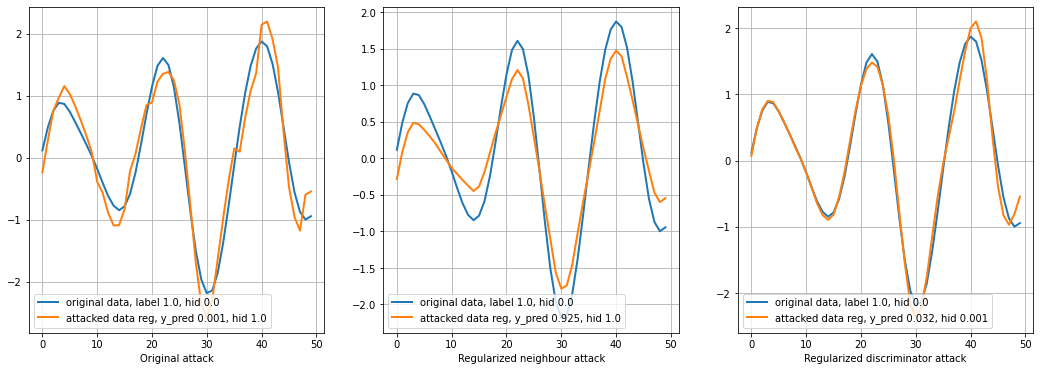

In [15]:
plt.figure(figsize=(18, 6))

label = y.item()
hid_orig = round(discriminator(x).item(), 3)

plt.subplot(1, 3, 1)

pred = round(model(x_attack).item(), 3)
hid_pred = round(discriminator(x_attack).item(), 3)
plt.plot(original_object[0], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_attack.cpu().detach().flatten(), 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2)
plt.legend()
plt.xlabel('Original attack')
plt.grid()

plt.subplot(1, 3, 2)

pred = round(model(x_reg_attack).item(), 3)
hid_pred = round(discriminator(x_reg_attack).item(), 3)
plt.plot(original_object[0], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_reg_attack.cpu().detach().flatten(), 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2)
plt.legend()
plt.grid()
plt.xlabel('Regularized neighbour attack')

plt.subplot(1, 3, 3)
pred = round(model(x_disc_attack).item(), 3)
hid_pred = round(discriminator(x_disc_attack).item(), 3)
plt.plot(original_object[0], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_disc_attack.cpu().detach().flatten(), 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2)
plt.legend()
plt.grid()
plt.xlabel('Regularized discriminator attack')


plt.show()

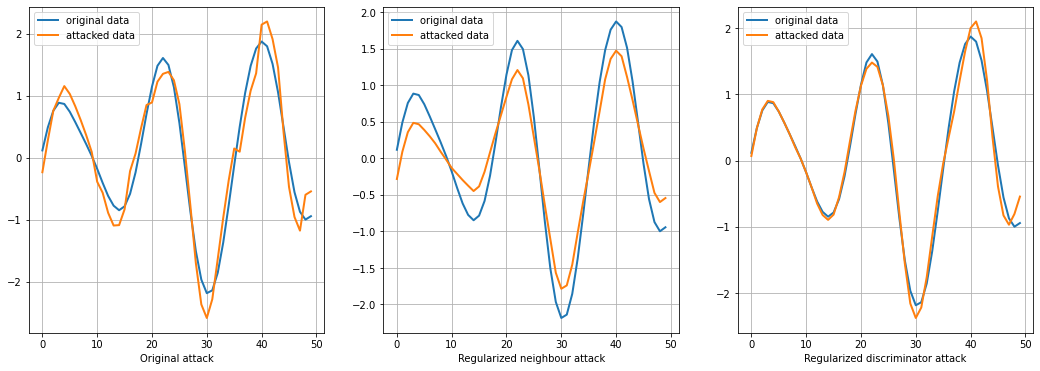

In [16]:
plt.figure(figsize=(18, 6))

label = y.item()
hid_orig = round(discriminator(x).item(), 3)

plt.subplot(1, 3, 1)

pred = round(model(x_attack).item(), 3)
hid_pred = round(discriminator(x_attack).item(), 3)
plt.plot(original_object[0], label=f'original data', lw=2)
plt.plot(x_attack.cpu().detach().flatten(), 
         label=f'attacked data', lw=2)
plt.legend()
plt.xlabel('Original attack')
plt.grid()

plt.subplot(1, 3, 2)

pred = round(model(x_reg_attack).item(), 3)
hid_pred = round(discriminator(x_reg_attack).item(), 3)
plt.plot(original_object[0], label=f'original data', lw=2)
plt.plot(x_reg_attack.cpu().detach().flatten(), 
         label=f'attacked data', lw=2)
plt.legend()
plt.grid()
plt.xlabel('Regularized neighbour attack')

plt.subplot(1, 3, 3)
pred = round(model(x_disc_attack).item(), 3)
hid_pred = round(discriminator(x_disc_attack).item(), 3)
plt.plot(original_object[0], label=f'original data', lw=2)
plt.plot(x_disc_attack.cpu().detach().flatten(), 
         label=f'attacked data', lw=2)
plt.legend()
plt.grid()
plt.xlabel('Regularized discriminator attack')


plt.show()

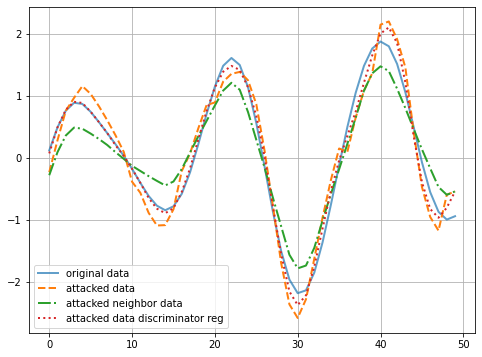

In [271]:
plt.figure(figsize=(8, 6))

plt.plot(original_object[0], label='original data', lw=2, alpha=0.7)
plt.plot(x_attack.cpu().detach().flatten(), label='attacked data', lw=2, linestyle='--')
plt.plot(x_reg_attack.cpu().detach().flatten(), label='attacked neighbor data ',lw=2, linestyle='dashdot')
plt.plot(x_disc_attack.cpu().detach().flatten(), label='attacked data discriminator reg', lw=2, linestyle=':')
plt.legend()
plt.grid()

plt.show()

tensor([0.], device='cuda:1')